<h1>UIDAI Aadhaar Dataset Analysis</h1>

The dataset concerned in this analysis is the Aadhaar enrollment data across India published by the UIDAI.
The dataset dealt with herein contains information up until March 2017. 
<br\>
The dataset contains salient features related to individual Aadhar enrollment attempts across the country. It contains registration information such as the Registrar and Enrollment Agency. We also have geographical information from State to District information of the applicants.
<br\>
The dataset also contains information related to demographic aspects of the applicants including Age and Gender of the applicants.
<br\>
Finally we are also presented with information that states if a particular applicant was ssuccessful in enrolling for the Aadhaar program.

<h2>Goals of the analysis</h2>

The goals of the analysis presented herein are listed below
<ol>
    <li>Extract the data from the available csv files.</li>
    <li>Ensure that the schema of the data is acceptable. This process involves checking data types of columns and ensuring consistent nomencletures for data columns</li>
    <li>Identify any issues related with data quality including but not limited to missing data, inconsistent data etc.</li>
    <li>Explore the data in the Exploratory Data Analysis section. This will include univariate or bivariate analyses and trying to extract relationships/co-relations between certain salient variables in the dataset</li>
    <li>Loading the cleaned data into a variety of data formats so that they may be readily available for future analyses.</li>
    <li>Listing the salient points of interest/inferences from the dataset and also specifying next potential next steps(if any)</li>
    
</ol>

<h2>Data Ingest</h2>

At the outset, we will load the necessary ibraries and packages that will be required for ingesting data, cleaning data and then creating visualisations and inferences in the Exploratory Data Analysis phase. Let us do just that in the subsequent stages.

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession, Row, SQLContext
from pyspark.sql import functions as F

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
spark = SparkSession.builder.config('spark.data.warehouse.dir', "file:///C:/temp").appName('Aadhar-analysis').getOrCreate()

In [5]:
df = spark.read.csv('./UIDAI-ENR-DETAIL-20170308.csv', header=True)

In [6]:
df.show(10, False)

+--------------+-----------------------------------+-------------+---------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+
|Registrar     |Enrolment Agency                   |State        |District |Sub District|Pin Code|Gender|Age|Aadhaar generated|Enrolment Rejected|Residents providing email|Residents providing mobile number|
+--------------+-----------------------------------+-------------+---------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+
|Allahabad Bank|A-Onerealtors Pvt Ltd              |Uttar Pradesh|Allahabad|Meja        |212303  |F     |7  |1                |0                 |0                        |1                                |
|Allahabad Bank|Asha Security Guard Services       |Uttar Pradesh|Sonbhadra|Robertsganj |231213  |M     |8  |1                |0                 |0                        |

<h2>Data Quality assessment and remedy</h2>

First of all, let us understand the dimensions of the dataset. Let us create a tuple containing the number of observations and columns of the dataframe

In [7]:
#printing shape of the dataframe
df_shape = (df.count(), len(df.columns))
print('The dataframe has {} observations and {} columns'.format(df_shape[0], df_shape[1]))

The dataframe has 440818 observations and 12 columns


Now let's assess the schema of the dataframe and identify any data quality issues that we may have to remedy 

In [8]:
df.printSchema()

root
 |-- Registrar: string (nullable = true)
 |-- Enrolment Agency: string (nullable = true)
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Sub District: string (nullable = true)
 |-- Pin Code: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Aadhaar generated: string (nullable = true)
 |-- Enrolment Rejected: string (nullable = true)
 |-- Residents providing email: string (nullable = true)
 |-- Residents providing mobile number: string (nullable = true)



Here we see that some column names have spaces between them that may pose a problem during further analysis and extraction. Let us rename these columns so as not to have any spaces in between and with one uniform convention

In [9]:
df = df.withColumnRenamed('Sub District','Sub_district')\
.withColumnRenamed('Enrolment Agency','Enrolment_agency')\
.withColumnRenamed('Pin Code','Pin_code')\
.withColumnRenamed('Aadhaar generated','Aadhaar_generated')\
.withColumnRenamed('Enrolment Rejected','Enrolment_rejected')\
.withColumnRenamed('Residents providing email','Residents_providing_email')\
.withColumnRenamed('Residents providing mobile number','Residents_providing_mobile_number')

Let us check if the changes are reflected

In [10]:
df.columns

['Registrar',
 'Enrolment_agency',
 'State',
 'District',
 'Sub_district',
 'Pin_code',
 'Gender',
 'Age',
 'Aadhaar_generated',
 'Enrolment_rejected',
 'Residents_providing_email',
 'Residents_providing_mobile_number']

Let us have a look at columns that we deem can have numeric values so that we can update the datatypes of the particular columns

In [11]:
df.select(['Age','Aadhaar_generated','Enrolment_rejected','Residents_providing_email','Residents_providing_mobile_number']).show(10)

+---+-----------------+------------------+-------------------------+---------------------------------+
|Age|Aadhaar_generated|Enrolment_rejected|Residents_providing_email|Residents_providing_mobile_number|
+---+-----------------+------------------+-------------------------+---------------------------------+
|  7|                1|                 0|                        0|                                1|
|  8|                1|                 0|                        0|                                0|
| 13|                1|                 0|                        0|                                1|
|  6|                1|                 0|                        0|                                1|
|  8|                1|                 0|                        0|                                1|
| 14|                1|                 0|                        0|                                1|
|  9|                1|                 0|                        0|     

<b>Note</b>: We are not considering the field Pin_code as numeric as standard numerical operations will not apply to it.

Let us change the datatype of these relavant fields. This will help us to attain descriptive statistics of these fields. After making the necessary changes, we will check if the updates are reflected in the new schema

In [12]:
#change datatype of Age column
df=df.withColumn('Age', df.Age.cast('int'))\
.withColumn('Aadhaar_generated', df.Aadhaar_generated.cast('int'))\
.withColumn('Enrolment_rejected', df.Enrolment_rejected.cast('int'))\
.withColumn('Residents_providing_email',df.Residents_providing_email.cast('int'))\
.withColumn('Residents_providing_mobile_number', df.Residents_providing_mobile_number.cast('int'))

In [13]:
df.printSchema()

root
 |-- Registrar: string (nullable = true)
 |-- Enrolment_agency: string (nullable = true)
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Sub_district: string (nullable = true)
 |-- Pin_code: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Aadhaar_generated: integer (nullable = true)
 |-- Enrolment_rejected: integer (nullable = true)
 |-- Residents_providing_email: integer (nullable = true)
 |-- Residents_providing_mobile_number: integer (nullable = true)



Let us have a look at the Gender column and have look at the values therein.

In [14]:
df.select('Gender').distinct().show()

+------+
|Gender|
+------+
|     F|
|     T|
|     M|
+------+



The Gender column has the first letters of the genders of the candidates. However, it would be better, if the Gender column were a bit more verbose. Let us replace the first letters of the Genders with the full genders.

In [15]:
df = df.withColumn('Gender',F.when(df.Gender=='M','Male').when(df.Gender=='F','Female').when(df.Gender=='T','Transgender'))

In [16]:
df.select('Gender').distinct().show()

+-----------+
|     Gender|
+-----------+
|     Female|
|Transgender|
|       Male|
+-----------+



Finally, there is one more issue that we have to deal with. The records contained within this dataframe are on an individual person basis. However we see that for multiple records the "Aadhar_generated", "Enrolment_rejected", "Residents_providing_email" and "Residents_providing_mobile_number" columns have a myriad range of values. In an ideal scenario, these columns should have binary values of 0 and 1 representing No and Yes respectively. These records may be due to multiple attempts that may have been made at Aadhar generation. So, we will replace a value other than 0 as a positive result and replace it with 1 for all of these columns.

In [17]:
df = df.withColumn('Aadhaar_generated', F.when(df.Aadhaar_generated!=0,1).otherwise(0))
df = df.withColumn('Enrolment_rejected', F.when(df.Enrolment_rejected!=0,1).otherwise(0))
df = df.withColumn('Residents_providing_email', F.when(df.Residents_providing_email!=0,1).otherwise(0))
df = df.withColumn('Residents_providing_mobile_number', F.when(df.Residents_providing_mobile_number!=0,1).otherwise(0))

Now, we should have exclusive data clusters where applicants have either successfully reveived Aadhar cards or they have not. Let's create some helper methods to aid us with this task

In [18]:
total_records = df.count()
total_states = df.select('State').distinct().count()

In [19]:
def percentage_of_success_or_reject(application_state='Success'):
    if application_state.strip()=='Success':
        successful_generation_count = df.filter(df['Aadhaar_generated']==1).count()
        successful_generation_percentage = successful_generation_count/total_records *100
        print('The percentage of successful Aadhar generation is {} %'.format(round(successful_generation_percentage,2)))
    elif application_state.strip()=='Reject':
        rejected_generation_count = df.filter(df['Enrolment_rejected']==1).count()
        rejected_generation_percentage = rejected_generation_count/total_records *100
        print('The percentage of people whose Aadhar generation was rejected is {} %'.format(round(rejected_generation_percentage,2)))
    else:
        print('You have provided an invalid Aadhaar application state')

In [20]:
percentage_of_success_or_reject('Success')

The percentage of successful Aadhar generation is 95.6 %


In [21]:
percentage_of_success_or_reject('Reject')

The percentage of people whose Aadhar generation was rejected is 7.16 %


Ideally, we would want the sum of successful generation and rejection to add up to 100 as these two conditions are mutually exclusive and collectively comprehensive. But here that does not seem to be the case. This may be due to an overlap between successful and rejected candidates. Let's test this out. 

In [22]:
df.filter((df['Aadhaar_generated']==1) & (df['Enrolment_rejected']==1)).count()

12143

In [23]:
df.filter((df['Aadhaar_generated']==0) & (df['Enrolment_rejected']==0)).count()

0

Thus we indeed see that there is an overlap. As the count of these overlaps is not so high in comparison to the dataset, we would do well to remove them from the dataset.

In [25]:
df = df.filter(~((df['Aadhaar_generated']==1) & (df['Enrolment_rejected']==1)))

Let's check now

In [26]:
df.filter((df['Aadhaar_generated']==1) & (df['Enrolment_rejected']==1)).count()

0

In [27]:
df.filter((df['Aadhaar_generated']==0) & (df['Enrolment_rejected']==0)).count()

0

Thus we are good to go. Let's update the totals and check the success and reject percentages again and tally the results

In [28]:
total_records = df.count()
total_states = df.select('State').distinct().count()

In [29]:
percentage_of_success_or_reject('Success')

The percentage of successful Aadhar generation is 95.47 %


In [30]:
percentage_of_success_or_reject('Reject')

The percentage of people whose Aadhar generation was rejected is 4.53 %


Indeed, now the sum of the two values do add up to be 100.

With these changes in place, we are now in a position to move on to the analysis of our dataset. Let us get started with that.

<h2>Exploratory Data Analysis</h2>

We will use a mixture of SQL syntax and programmatic queries for the purposes for our data analysis.
For the purposes of our analysis we will be creating a TempView provided by the Spark engine. As we will not be performing our analysis on the cluster and as it would suit us well if the View were limited to the current session, the usage of a TempView should be just fine. Let us proceed along thos lines.

In [31]:
df.createOrReplaceTempView('aadhar_info')

<b>Note:</b>In this workbook, code samples have been provided for SQL syntax of querying dataframe. However the analogous programmatic syntax has also been provided in commented form in each cell below the SQL syntax.

<h3>Univariate Analysis</h3>

First let us get an idea of the important numerical variable in our dataset viz. the age.

In [32]:
res = df.select('Age').describe()
res = res.withColumn('Age',F.round(res.Age,2))
res.show()

+-------+--------+
|summary|     Age|
+-------+--------+
|  count|428675.0|
|   mean|    20.1|
| stddev|   18.75|
|    min|     0.0|
|    max|   118.0|
+-------+--------+



A probability density distribution of the age variable would be beneficial for our analysis.

Text(0.5,1,'Probability density distribution of Applicant Age')

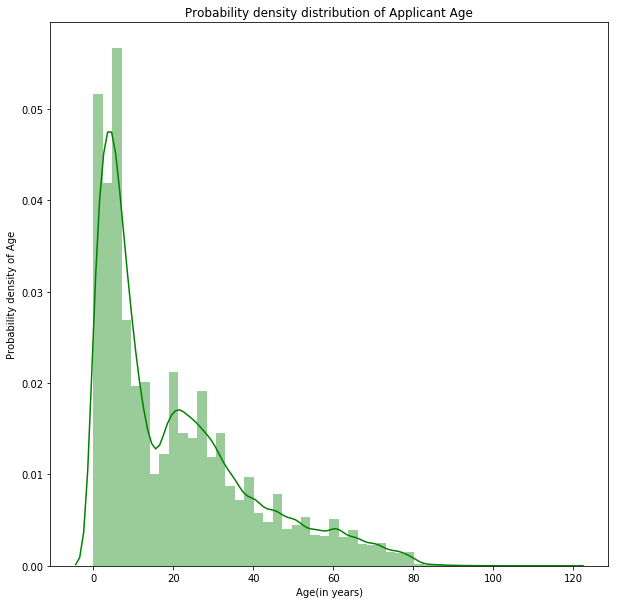

In [33]:
res = df.select(['Age','Gender'])
res_pandas = res.toPandas()
fig, axes = plt.subplots(1,1,figsize=(10,10))

ax_dist = sns.distplot(res_pandas['Age'], ax=axes, color='green')
ax_dist.set_xlabel('Age(in years)')
ax_dist.set_ylabel('Probability density of Age')
ax_dist.set_title('Probability density distribution of Applicant Age')




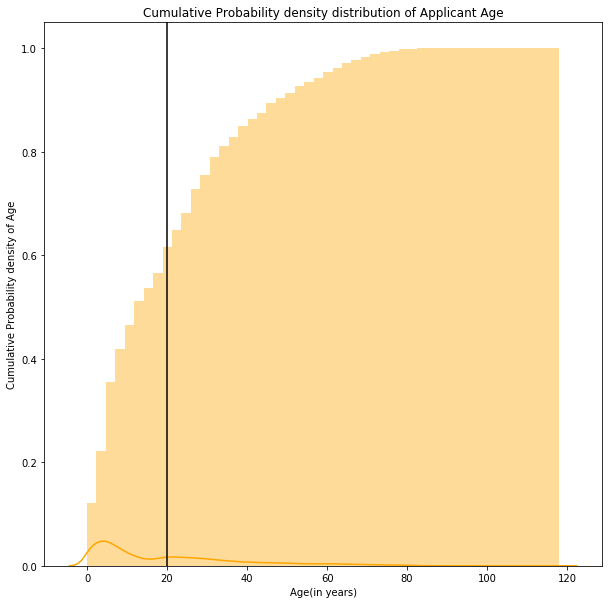

In [34]:
fig, axes = plt.subplots(1,1,figsize=(10,10))

ax_dist = sns.distplot(res_pandas['Age'], ax=axes, color='orange', hist_kws={'cumulative':True})
ax_dist.set_xlabel('Age(in years)')
ax_dist.set_ylabel('Cumulative Probability density of Age')
ax_dist.set_title('Cumulative Probability density distribution of Applicant Age')
ax_dist = plt.axvline(20, color='black')

As we can see from the plot above, a majority of people applied for Aadhar towards the closing periods of their teenage years.
The plot has a distinct right skew and tapers off sharply after the age of approximately 80.

The cumulative probability distribution of the Age variable shows us that almost 60% of applicants have an age lesser than or equal to 20.

Next, let us get an idea of Aadhar applications according to Gender.

In [35]:
res = spark.sql('SELECT Gender, COUNT(1) AS count FROM aadhar_info GROUP BY Gender ORDER BY 2 DESC')
res.show()

#res = df.groupBy('Gender').count().sort('count', ascending=False)
#res.show()

+-----------+------+
|     Gender| count|
+-----------+------+
|       Male|284580|
|     Female|144088|
|Transgender|     7|
+-----------+------+



A visualisation of the above trend would be in order

Text(0.5,1,'Barchart for Gender distribution of applicants')

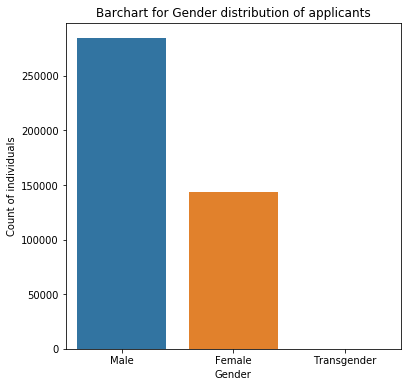

In [36]:
res_pandas = res.toPandas()

fig, axes = plt.subplots(1,1,figsize=(6,6))

ax_bar = sns.barplot(x=res_pandas['Gender'],y=res_pandas['count'], ax=axes)
ax_bar.set_xlabel('Gender')
ax_bar.set_ylabel('Count of individuals')
ax_bar.set_title('Barchart for Gender distribution of applicants')

We see that Aadhar applications for males are almost twice that for females. This is somewhat surprising as the difference is grossly different from the sex-ratio in our country. Thus we see from this data sample that tendency of males to try to enroll in the Aadhar program is much more than that of females.
Also surprising is the fact that so few transgender individuals applied for Aadhar, especially where Aadhar is a necessary government identification and there are no restrictions for an Indian citizen in its enrollment process.

We might also pose a question as to the most common Registrars. Such a question is addressed below

In [37]:
#top 10 most common registrars
res = spark.sql("SELECT Registrar, ROUND(COUNT(1)/{},2) AS Count FROM aadhar_info \
                GROUP BY Registrar\
                ORDER BY 2 DESC LIMIT 10".format(total_records))
res.show(10,False)

+---------------------------------------------------------------+-----+
|Registrar                                                      |Count|
+---------------------------------------------------------------+-----+
|CSC e-Governance Services India Limited                        |0.48 |
|NSDL e-Governance Infrastructure Limited                       |0.12 |
|DENA BANK                                                      |0.08 |
|Tamil Nadu eGovernance Agency                                  |0.04 |
|Madhya Pradesh State Electronics Development Corporation Ltd.  |0.04 |
|Bank Of India                                                  |0.04 |
|Govt of Kerala                                                 |0.03 |
|Govt of Gujarat                                                |0.03 |
|Dept of ITC Govt of Rajasthan                                  |0.03 |
|State Bank of India                                            |0.01 |
+---------------------------------------------------------------

It seems that e-Governance wings of the Common Services Centres and National Securities Depository Limited were successful in amassing the most number of applications, together accounting for almost 60% of all applications. It seems that these e-governance initiatives of the Central Government are indeed doing their job!!

Another obvious question is the count of applicants per state. For the purposed of our analysis we will limit our analysis to the top 10 states with highest applicant volume. Also instead of raw numbers, we will consider each state's contributin as a proprtion of the total applicant base

In [38]:
#top 3 states in terms of enrolment applications

res = spark.sql("SELECT State, ROUND(COUNT(1)/{},2) AS proportion FROM aadhar_info \
                GROUP BY State\
                ORDER BY 2 DESC LIMIT 10".format(total_records))
res.show()

#res = df.groupBy('State').count().sort('count',ascending=False).limit(10)
#res = res.withColumn('count',F.round(res[1]/total_records,2))
#res.show()

+--------------+----------+
|         State|proportion|
+--------------+----------+
|         Bihar|      0.19|
| Uttar Pradesh|      0.16|
|   West Bengal|      0.14|
|Madhya Pradesh|      0.08|
|     Rajasthan|      0.07|
|    Tamil Nadu|      0.05|
|       Gujarat|      0.05|
|     Karnataka|      0.04|
|   Maharashtra|      0.04|
|        Odisha|      0.03|
+--------------+----------+



We can visualise the distribution better with a barplot

[Text(0,0,'Bihar'),
 Text(0,0,'Uttar Pradesh'),
 Text(0,0,'West Bengal'),
 Text(0,0,'Madhya Pradesh'),
 Text(0,0,'Rajasthan'),
 Text(0,0,'Tamil Nadu'),
 Text(0,0,'Gujarat'),
 Text(0,0,'Karnataka'),
 Text(0,0,'Maharashtra'),
 Text(0,0,'Odisha')]

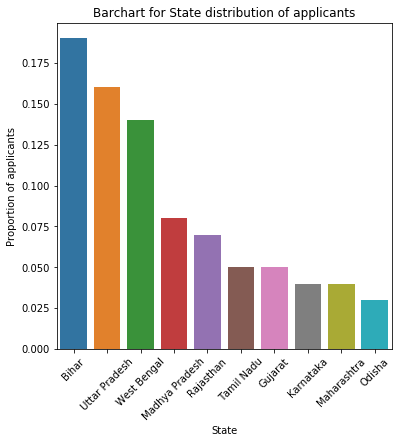

In [39]:
res_pandas = res.toPandas()

fig, axes = plt.subplots(1,1,figsize=(6,6))

ax_bar = sns.barplot(x=res_pandas.iloc[:,0],y=res_pandas.iloc[:,1], ax=axes)
ax_bar.set_xlabel('State')
ax_bar.set_ylabel('Proportion of applicants')
ax_bar.set_title('Barchart for State distribution of applicants')
ax_bar.set_xticklabels(labels=res_pandas['State'],rotation=45)


We can now see that the top 3 states acoount for almost 50% of the applicant base for Aadhaar card. This does make sense however as the 3 states fall within the top 4 populous states in India. It is a little surprising that Maharashtra lies so far down the line as it the 2nd most populous state in the country.

Also, it would be beneficial to get an understanding of distribution among districts the same way we did for states. Obviously we will include the State info for reference ,and technically, the inclusion will not violate the analysis being "univariate"

In [40]:
#top 3 districts in terms of enrolment applications
res = spark.sql("SELECT District,State, ROUND(COUNT(1)/{},4) AS proportion FROM aadhar_info \
                GROUP BY District, State\
                ORDER BY 3 DESC LIMIT 10".format(total_records))
res.show()

#res = df.groupBy(['District', 'State']).count().sort('count',ascending=False).limit(10)
#res = res.withColumn('proportion',F.round(res[2]/total_records,4))
#res = res.drop('count')
#res.show()


+-----------------+-----------+----------+
|         District|      State|proportion|
+-----------------+-----------+----------+
|       Barddhaman|West Bengal|    0.0163|
|North 24 Parganas|West Bengal|    0.0157|
|South 24 Parganas|West Bengal|    0.0137|
|            Patna|      Bihar|    0.0118|
|        Bhagalpur|      Bihar|    0.0118|
|            Nadia|West Bengal|    0.0117|
|             Gaya|      Bihar|    0.0099|
|      Murshidabad|West Bengal|    0.0099|
|          Kolkata|West Bengal|    0.0092|
|          Katihar|      Bihar|    0.0087|
+-----------------+-----------+----------+



It is surprising to see that although the top 3 districts with highest application density are in West Bengal, the state itself is only the 3rd in terms of overall application. This may be because Bihar and UP have larger number of districts that contribute more to their total contribution than does West Bengal.

This concludes our section for univariate analysis.

<h3>Bivariate and Multivariate analysis</h3>

This section will deal with the interactions and co-relations between the different features of the dataset.

An immediate point of interest, is the ages average ages of applicants across genders. Let us try to ascertain that

In [41]:
#average ages across genders
res = spark.sql("SELECT Gender, ROUND(AVG(Age),2) AS Average_Age FROM aadhar_info\
                GROUP BY Gender\
                ORDER BY 2 DESC")
res.show()

#res = df.groupBy('Gender').avg('Age').sort('avg(Age)', ascending=False)
#res = res.withColumn('avg(Age)', F.round(res[1],2))
#res.show()

+-----------+-----------+
|     Gender|Average_Age|
+-----------+-----------+
|Transgender|      21.43|
|       Male|       21.2|
|     Female|      17.91|
+-----------+-----------+



Text(0.5,1,'Boxplot of age across genders of applicants')

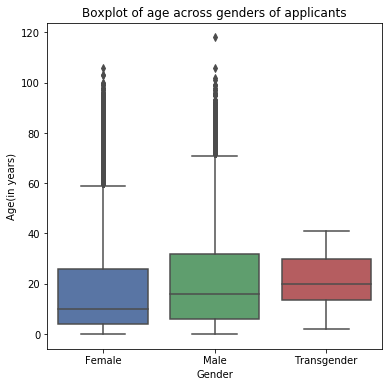

In [42]:
res = df.select(['Age','Gender'])
res_pandas = res.toPandas()
fig, axes = plt.subplots(1,1,figsize=(6,6))

ax_box = sns.boxplot(x='Gender',y='Age', data=res_pandas, ax=axes, palette='deep')
ax_box.set_xlabel('Gender')
ax_box.set_ylabel('Age(in years)')
ax_box.set_title('Boxplot of age across genders of applicants')

It seems that although women apply to enroll at much lesser volumes than men, they do so at the earliest of ages. Transgender individuals and men apply typically past their teens. We also notice that the IQR for men is the largest among all three genders meaning that men apply for Aadhar over the widest range of ages.

Next of interest is the average age of erollment application across states.

In [43]:
#average ages across states
res = spark.sql("SELECT State, ROUND(AVG(Age),2) AS Average_Age FROM aadhar_info\
                GROUP BY State\
                ORDER BY 2 DESC")
res.show(100)

#res = df.groupBy('State').avg('Age').sort('avg(Age)', ascending=False)
#res = res.withColumn('avg(Age)',F.round(res[1],2))
#res.show(100)

+--------------------+-----------+
|               State|Average_Age|
+--------------------+-----------+
|         Lakshadweep|       35.0|
|             Mizoram|      34.02|
|       Daman and Diu|      32.82|
|              Others|      32.42|
|           Meghalaya|      32.31|
|   Jammu and Kashmir|      28.98|
|               Assam|       28.2|
|            Nagaland|      27.78|
|              Kerala|      27.28|
|         West Bengal|      23.62|
|             Gujarat|      23.22|
|          Tamil Nadu|      22.82|
|              Punjab|      22.58|
|   Arunachal Pradesh|      21.26|
|              Odisha|      20.95|
|       Uttar Pradesh|      20.65|
|               Bihar|      19.57|
|      Madhya Pradesh|      19.31|
|             Tripura|      18.78|
|             Manipur|      18.71|
|          Puducherry|      18.67|
|           Karnataka|      17.89|
|         Maharashtra|      17.04|
|               Delhi|      16.83|
|Dadra and Nagar H...|      16.83|
|         Uttarakhan

Let us now focus on successful Aadhar generation statistics across genders.

We also need to ascertain the proportion of people across states that have had their Aadhar successfully generated. For this purpose we need to perform a join operation across two sets of dataframes. We will also extract the total number of applicants per state to see if there is a co-relation between successful acpplications and total number of applicants. The following code demonstrates that startegy.

In [47]:
res_total = df.groupBy('Gender').count()
res_gen = df.filter(df['Aadhaar_generated']==1).groupBy('Gender').count()

res = res_gen.join(res_total,res_total.Gender==res_gen.Gender,'inner')\
.select(res_gen.Gender,res_gen[1].alias('Successfully_generated'), res_total[1].alias('Total_Count'))

res = res.withColumn('Percentage_success', F.round((res[1]/res[2])*100,2))

res = res.sort('Percentage_success', ascending=False)

res.show()

+-----------+----------------------+-----------+------------------+
|     Gender|Successfully_generated|Total_Count|Percentage_success|
+-----------+----------------------+-----------+------------------+
|       Male|                274122|     284580|             96.33|
|     Female|                135147|     144088|             93.79|
|Transgender|                     6|          7|             85.71|
+-----------+----------------------+-----------+------------------+



Text(0.5,1,'Successful Aadhaar generation across Genders ')

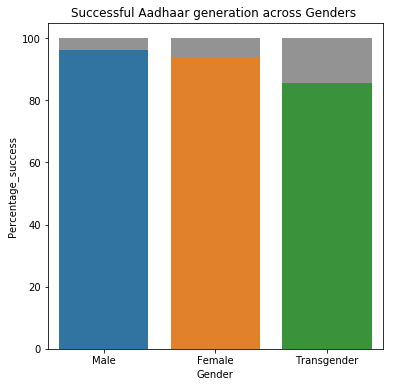

In [51]:
res_pandas = res.toPandas()

fig, axes = plt.subplots(1,1,figsize=(6,6))

axes = sns.barplot(x=res_pandas['Gender'], y=np.array([100,100,100]), color='#939393', ax=axes)
axes = sns.barplot(x=res_pandas['Gender'], y=res_pandas['Percentage_success'], ax=axes)
axes.set_title('Successful Aadhaar generation across Genders ')

We can see that males, despite having the largest applicant base, also have the highest successful percentage conversion across genders. Transgender individuals have the lowest conversion rate. However, this should not be construed as serious as the sample set for Transgender personnel is immensely dimunitive to begin with. Further data needs to be collected before conclusive inferences can be made. 

In [52]:
res_total = df.groupBy('State').count()
res_gen = df.filter(df['Aadhaar_generated']==1).groupBy('State').count()

res = res_gen.join(res_total,res_total.State==res_gen.State,'inner')\
.select(res_gen.State,F.round((res_gen[1]/res_total[1])*100,2).alias('success_percentage'),res_total[1])

res = res.sort(res[1],ascending=False)

res.show(total_states)

+--------------------+------------------+-----+
|               State|success_percentage|count|
+--------------------+------------------+-----+
|              Others|             100.0|   12|
|               Assam|             99.26| 2966|
|           Meghalaya|             99.23|  259|
|             Mizoram|             98.18| 3082|
|       Daman and Diu|             97.98|   99|
|              Kerala|             97.22|12208|
|Dadra and Nagar H...|              97.2|  107|
|          Chandigarh|             96.94|  196|
|          Tamil Nadu|             96.29|20898|
|               Bihar|             96.24|79334|
|           Telangana|             96.03| 3678|
|           Rajasthan|             95.92|28010|
|              Sikkim|             95.83|   48|
|       Uttar Pradesh|              95.8|67942|
|         Uttarakhand|             95.76| 6110|
|        Chhattisgarh|             95.65| 4463|
|           Jharkhand|             95.58| 7301|
|      Madhya Pradesh|              95.4

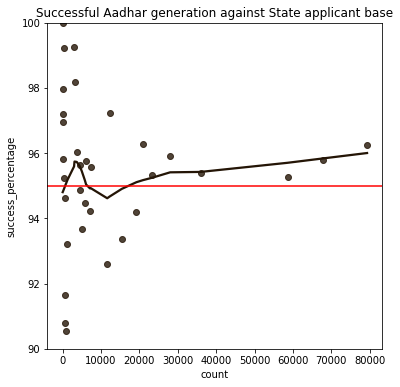

In [53]:
res_pandas = res.toPandas()
fig, axes = plt. subplots(1,1,figsize=(6,6))
axes = sns.regplot(x='count',y='success_percentage', data=res_pandas, lowess=True, color='#241506')
axes.set_ylim(90,100)
axes.set_title('Successful Aadhar generation against State applicant base')
axes.axhline(95, color='red')

The plot, although not confirmative of a strict relationship, is quite insightful nonetheless. We see that successful application rates have a higher variance for states where application base is on the lower side. Thus there are both a mixture of high successful application rates and low successful application rates. As the applicant base increases, the successful conversion rate starts to taper and for applicant counts higher than 30,000 we see that the successful applicant rate narrows down to a small band.

<h2>Loading cleaned data</h2>


We will now load the data into three data structure formats viz. csv, json and parquet. The cleaned datasets will be available to users for further analysis. Once exported we will load these files using pandas to confirm the correctness of the schema.

In [54]:
import os, win32api, win32con

In [55]:
def load_file(file_path, file_format,*args,**kwargs):
    if os.path.exists(file_path):
        win32api.SetFileAttributes(file_path, win32con.FILE_ATTRIBUTE_NORMAL)
        os.remove(file_path)
        
    header_info=kwargs['header'] if 'header' in kwargs else None
    
    try:
        df.write.save(file_path, format=file_format, header=header_info) 
        print('File created successfully')
    except:
        print('A problem was encountered. The file could not be created!')
    

<h3>Load cleaned data into csv</h3>

In [56]:
load_file('./cleaned-data/Aadhar-data-20170308.csv', 'csv', header=True)

File created successfully


Let's load the data into a frame

In [57]:
df_csv=spark.read.csv('./cleaned-data/Aadhar-data-20170308.csv', header=True)

In [58]:
df_csv.limit(5).show()

+--------------------+----------------+-------------+--------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+
|           Registrar|Enrolment_agency|        State|District|Sub_district|Pin_code|Gender|Age|Aadhaar_generated|Enrolment_rejected|Residents_providing_email|Residents_providing_mobile_number|
+--------------------+----------------+-------------+--------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+
|CSC e-Governance ...|         CSC SPV|Uttar Pradesh|  Amethi|Musafirkhana|  227816|  Male|  0|                1|                 0|                        0|                                1|
|CSC e-Governance ...|         CSC SPV|Uttar Pradesh|  Amethi|Musafirkhana|  227816|  Male| 26|                1|                 0|                        0|                                1|
|CSC e-Governance ...|         CSC 

In [59]:
print((df_csv.count(),len(df.columns)))

(428675, 12)


<h3>Load cleaned data into json</h3>

In [60]:
load_file('./cleaned-data/Aadhar-data-20170308.json', 'json')

File created successfully


Let's now try to fetch the data from this json file and load it into a dataframe

In [61]:
df_json = spark.read.load('./cleaned-data/Aadhar-data-20170308.json', format='json')

In [62]:
df.limit(5).show()

+--------------+--------------------+-------------+---------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+
|     Registrar|    Enrolment_agency|        State| District|Sub_district|Pin_code|Gender|Age|Aadhaar_generated|Enrolment_rejected|Residents_providing_email|Residents_providing_mobile_number|
+--------------+--------------------+-------------+---------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+
|Allahabad Bank|A-Onerealtors Pvt...|Uttar Pradesh|Allahabad|        Meja|  212303|Female|  7|                1|                 0|                        0|                                1|
|Allahabad Bank|Asha Security Gua...|Uttar Pradesh|Sonbhadra| Robertsganj|  231213|  Male|  8|                1|                 0|                        0|                                0|
|Allahabad Bank|   SGS INDIA PVT LTD|Utt

In [63]:
print((df_json.count(),len(df.columns)))

(428675, 12)


It looks as if the data has been correctly populated. Let us now move on to our next data format viz. parquet files.
The steps will be the same as in the case of the json process.

<h3>Load cleaned data into parquet</h3>

In [64]:
load_file('./cleaned-data/Aadhar-data-20170308.parquet', 'parquet')

File created successfully


And likewise, let us load the data.

In [65]:
df_parquet = spark.read.load('./cleaned-data/Aadhar-data-20170308.parquet')
df_parquet.limit(5).show()

+---------+--------------------+--------------+--------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+
|Registrar|    Enrolment_agency|         State|District|Sub_district|Pin_code|Gender|Age|Aadhaar_generated|Enrolment_rejected|Residents_providing_email|Residents_providing_mobile_number|
+---------+--------------------+--------------+--------+------------+--------+------+---+-----------------+------------------+-------------------------+---------------------------------+
|DENA BANK|Mahamritunjay Tra...|Madhya Pradesh|   Damoh|      Patera|  470772|  Male| 35|                1|                 0|                        0|                                0|
|DENA BANK|Mahamritunjay Tra...|Madhya Pradesh|   Damoh|      Patera|  470772|  Male| 37|                1|                 0|                        0|                                1|
|DENA BANK|Mahamritunjay Tra...|Madhya Pradesh|   Damoh|      Pat

In [66]:
print((df_parquet.count(),len(df.columns)))

(428675, 12)


<h2>Inferences, Conclusions and Next Steps</h2>

<h3>The main findings from the dataset are presented below</h3>

<ol>
    <li>Ages of applicants typically tend to be more on the lower side with almost 60% of applicants having and age less than or equal to 20 years. </li>
    <li>There are almost double the number of male applicants as femaile applicants. Transgender applicants are quite insignificant as compared to the two other genders.</li>
    <li>Bihar, UP and West Bengal have the highest number of applicants, their combined applicant base occupying 50% of the entire base.</li>
    <li>On an average, females tend to apply at a lower age than men. Transgender individuals apply at the highest age.</li>
    <li>On an average, men stand a slightly better chance than women in terms of successfully acquiring an Aadhaar. 
        For Transgender individuals, sufficient data is not available to make any concrete inferences.
    </li>
    <li>The percentage of successful Aadhar generation varies a great deal among states with lower applicant base.
        As the state applicant base increases, the degree of variance among the successful applicant base tends to decrease.
    </li>
</ol>

<h3>Next steps</h3>

While we were able to derive certain useful insights into the Aadhar aaplication process across the country. We saw how successful Aadhar generation hahd certain co-relations with the Gender of applicant and the applicant bas of the State. I think a logical next step would be devise a Machine Learning model that would be able to predict, given the various details of the candidate, the probability of successful Aadhar generation. However, we may need to amass additional information such as Income demographic, educational details etc. Given this additional information, we may be able to create Logistic Regression or Kernelised SVM model that can provide us with the probability of successful generation of a candidate, to a certain degree of accuracy.